In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np

##Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p "/content/drive/My Drive/Colab Notebooks/summer_challenge/Final"

!unzip -q "/content/drive/My Drive/Colab Notebooks/summer_challenge/Training.zip" -d "/content/drive/My Drive/Colab Notebooks/summer_challenge"
!unzip -q "/content/drive/My Drive/Colab Notebooks/summer_challenge/Final.zip" -d "/content/drive/My Drive/Colab Notebooks/summer_challenge/Final"

replace /content/drive/My Drive/Colab Notebooks/summer_challenge/Training/RGBImages/RGB_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace /content/drive/My Drive/Colab Notebooks/summer_challenge/Final/DepthImages/Depth_7.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/summer_challenge/Training/Train.csv")
rgb_dir = "/content/drive/My Drive/Colab Notebooks/summer_challenge/Training/RGBImages"
depth_dir = "/content/drive/My Drive/Colab Notebooks/summer_challenge/Training/DepthImages"


## Data Checks

In [17]:
# Check missing values
train_df.isna().sum()

,0
image_id,0
Height,0
Diameter,0
LeafArea,0
FreshWeightShoot,0
Variety,0
DryWeightShoot,0


In [19]:
#missing images
missing_rgb = []
missing_depth = []

for name in train_df["image_id"]:
    rgb_path = os.path.join(rgb_dir, f"RGB_{name}.png")
    depth_path = os.path.join(depth_dir, f"Depth_{name}.png")

    if not os.path.exists(rgb_path):
        missing_rgb.append(name)

    if not os.path.exists(depth_path):
        missing_depth.append(name)

print("Missing RGB images:", len(missing_rgb))
print("Missing Depth images:", len(missing_depth))

Missing RGB images: 1
Missing Depth images: 0


In [21]:
print(missing_rgb)

[332]


In [22]:
#Removing image 332 from training - can't train without RGB image.
train_df = train_df[train_df["image_id"] != 332].reset_index(drop=True)

In [38]:
#Checking for consistent image dimensions

rgb_shapes = set()
depth_shapes = set()


for name in train_df["image_id"].head(200):  # sample first 200 to save time
  rgb_img = cv2.imread(os.path.join(rgb_dir, f"RGB_{name}.png"))
  if rgb_img is not None:
      rgb_shapes.add(rgb_img.shape)

  # IMREAD_UNCHANGED loads 16‑bit depth image with one channel per pixel, not three
  depth_img = cv2.imread(os.path.join(depth_dir, f"Depth_{name}.png"), cv2.IMREAD_UNCHANGED)
  if depth_img is not None:
      depth_shapes.add(depth_img.shape)

print(rgb_shapes)
print(depth_shapes)

{(1080, 1920, 3)}
{(1080, 1920)}


## Distribution of Target Variable - DryWeightShoot

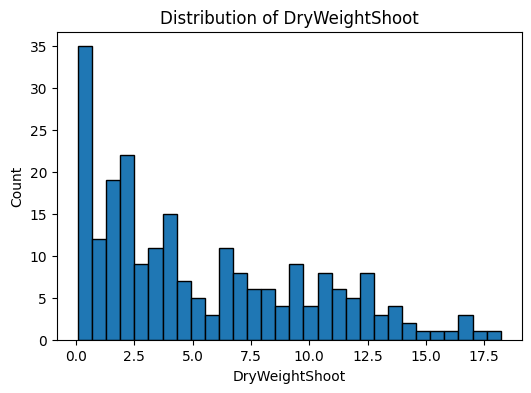

,DryWeightShoot
count,230.000000
mean,5.433609
std,4.562642
min,0.090000
25%,1.682500
50%,3.895000
75%,8.897500
max,18.210000


In [23]:
# Histogram
plt.figure(figsize=(6,4))
plt.hist(train_df["DryWeightShoot"], bins=30, edgecolor='black')
plt.xlabel("DryWeightShoot")
plt.ylabel("Count")
plt.title("Distribution of DryWeightShoot")
plt.show()

# Basic stats
train_df["DryWeightShoot"].describe()

##Feature Correlations

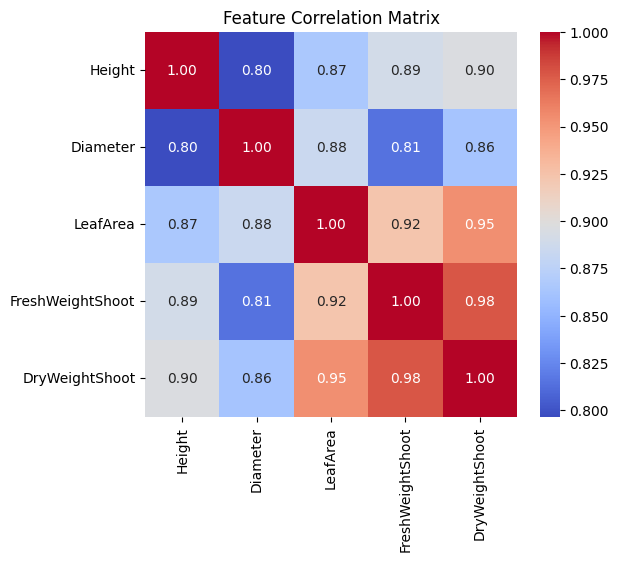

,DryWeightShoot
DryWeightShoot,1.000000
FreshWeightShoot,0.978007
LeafArea,0.954087
Height,0.896331
Diameter,0.862334


In [24]:
cols = ["Height", "Diameter", "LeafArea", "FreshWeightShoot", "DryWeightShoot"]
corr = train_df[cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

corr["DryWeightShoot"].sort_values(ascending=False)

##Variety Distribution

In [29]:
# Count plants per variety
variety_counts = train_df["Variety"].value_counts()

variety_counts

,count
Variety,
Salanova,60
Satine,58
Lugano,57
Aphylion,55


/tmp/ipython-input-2264295385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="Variety", y="DryWeightShoot", palette="magma")


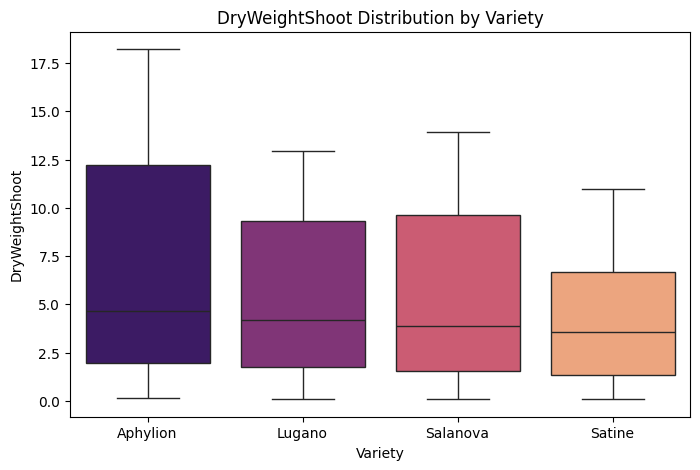

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(data=train_df, x="Variety", y="DryWeightShoot", palette="magma")
plt.title("DryWeightShoot Distribution by Variety")
plt.xlabel("Variety")
plt.ylabel("DryWeightShoot")
plt.show()

##Image Inspection

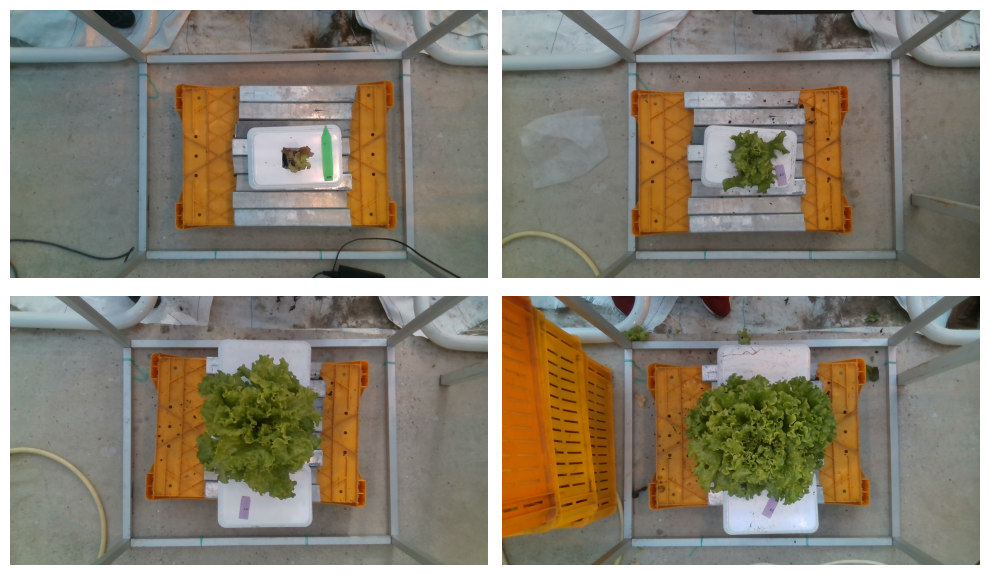

In [25]:
# Pick a few sample filenames
samples = train_df.sort_values("DryWeightShoot").iloc[[0, 50, -50, -1]]["image_id"].tolist() #smallest, med, large, largest

plt.figure(figsize=(10,6))
for i, name in enumerate(samples):
    img = cv2.imread(os.path.join(rgb_dir, f"RGB_{name}.png"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


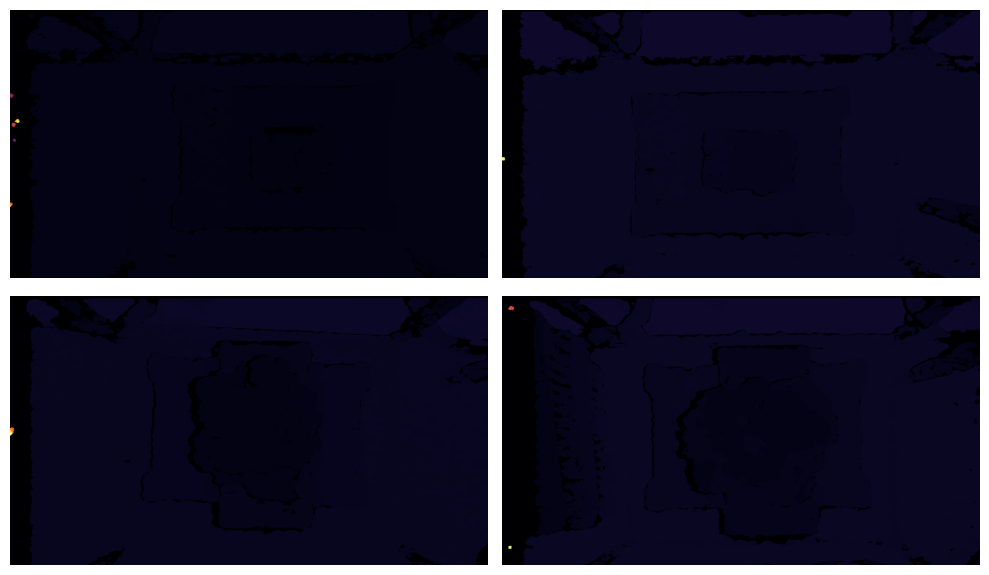

In [26]:
plt.figure(figsize=(10,6))

for i, name in enumerate(samples):
    # IMREAD_UNCHANGED loads 16‑bit depth image with one channel per pixel, not three
    depth = cv2.imread(os.path.join(depth_dir, f"Depth_{name}.png"), cv2.IMREAD_UNCHANGED)
    plt.subplot(2, 2, i+1)
    plt.imshow(depth, cmap="inferno")
    plt.axis("off")

plt.tight_layout()
plt.show()


##DepthImage Normalization

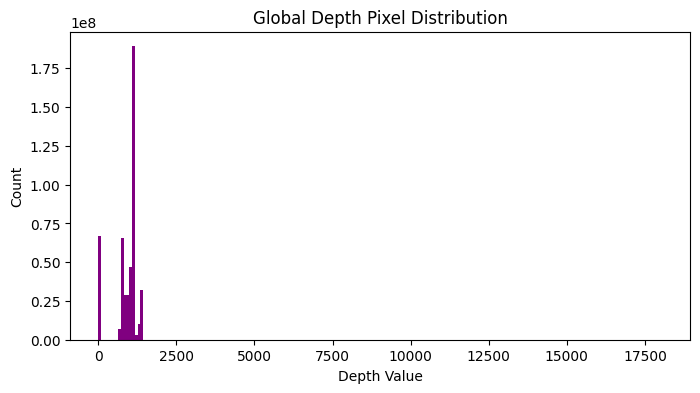

Global min: 0
Global max: 18040


In [27]:
all_pixels = []

for fname in os.listdir(depth_dir):
    depth = cv2.imread(os.path.join(depth_dir, f"Depth_{name}.png"), cv2.IMREAD_UNCHANGED)
    all_pixels.append(depth.flatten())

all_pixels = np.concatenate(all_pixels)

plt.figure(figsize=(8,4))
plt.hist(all_pixels, bins=200, color='purple')
plt.title("Global Depth Pixel Distribution")
plt.xlabel("Depth Value")
plt.ylabel("Count")
plt.show()

print("Global min:", all_pixels.min())
print("Global max:", all_pixels.max())


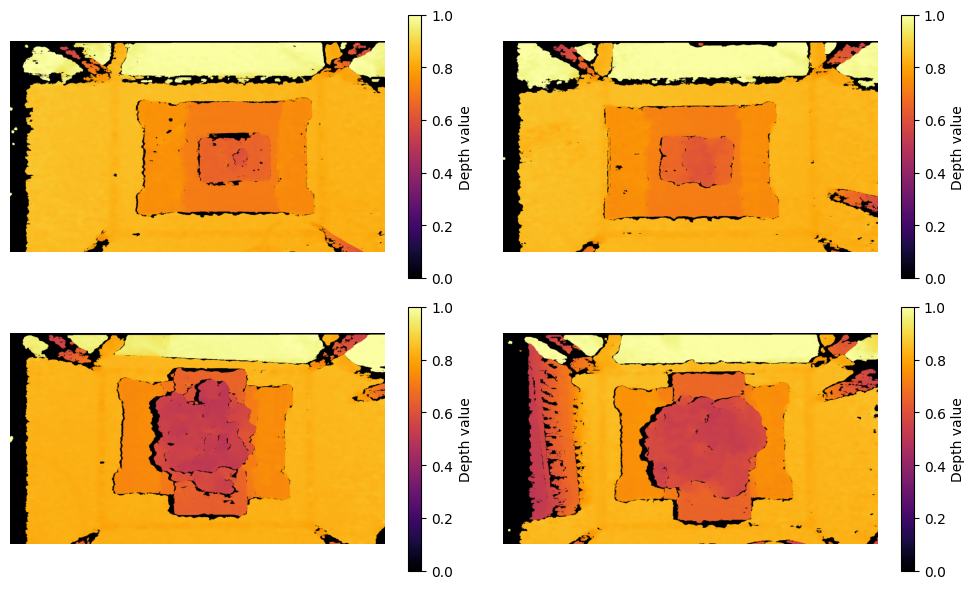

In [28]:
normalized_depths = []

for name in samples:
    depth = cv2.imread(os.path.join(depth_dir, f"Depth_{name}.png"), cv2.IMREAD_UNCHANGED).astype("float32") #convert to float instead of 16-bit int before performing normalization

    #clip outliers
    vmin = np.percentile(depth, 1)
    vmax = np.percentile(depth, 99)
    depth_clipped = np.clip(depth, vmin, vmax)

    # Normalize
    depth_norm = (depth_clipped - depth_clipped.min()) / (depth_clipped.max() - depth_clipped.min())
    normalized_depths.append(depth_norm)

plt.figure(figsize=(10,6))

for i, depth_norm in enumerate(normalized_depths):
    plt.subplot(2, 2, i+1)
    plt.imshow(depth_norm, cmap="inferno")
    plt.colorbar(label="Depth value")
    plt.axis("off")

plt.tight_layout()
plt.show()